# 1. Introduction
- 이 노트는 기본 학습 모델, 특히 스태킹으로 알려진 앙상발의 조합 방법에 대한 매우 기본적이고 간단한 입문서입니다. 간단히 말해 몇가지 기본 분류기의 예측을 첫 번째 수준으로 사용한 다음 두 번째 수준에서 다른 모델을 사용하여 이전 첫 번째 수준 예측의 출력을 예측합니다.

In [1]:
import pandas as pd
import numpy as np
import re
import sklearn
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

import warnings
warnings.filterwarnings('ignore')

from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier, 
                                GradientBoostingClassifier, GradientBoostingClassifier)
from sklearn.svm import SVC
from sklearn.model_selection import KFold

# 2. Feature Exploration, Engineering and Cleaning

- 일반적으로 대부분의 커널이 구조화되는 방식과 매우 유사하게 진행될 것이며
- 먼저 보유한 데이터를 탐색하고
- 가능한 feature engineering 기회를 식별하고
- 모든 범주형 feature을 수치화시킴.

## 2-1. Feature Exploration

In [2]:
# Load in the train and test datasets
train = pd.read_csv("../input/titanic/train.csv")
test = pd.read_csv("../input/titanic/train.csv")

# Store out passenger ID for easy access
PassengerId = test['PassengerId']

train.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


## 2-2. Feature Engineering

In [3]:
full_data = [train,test]

# Some features of my own that I have added in
# Gives the length of the name

# apply 함수 : 행 또는 열 또는 전체의 셀(=원소)에 원하는 연산을 지원
train['Name_length'] = train['Name'].apply(len)
test['Name_length'] = test['Name'].apply(len)

# Feature that tells whether a passenger had a cabin on the Titanic
train['Has_Cabin'] = train['Cabin'].apply(lambda x: 0 if type(x)==float else 1)
test['Has_Cabin'] = test['Cabin'].apply(lambda x: 0 if type(x)==float else 1)

In [4]:
# Create new feature FamilySize as a combination of SibSp and Parch
for dataset in full_data:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1

# Create new feature IsAlone from FamilySize
for dataset in full_data:
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1

In [5]:
# Remove all NULLS in the Embarked column
for dataset in full_data:
    dataset['Embarked'] = dataset['Embarked'].fillna('S')

# Remove all NULLS in the Fare column and create a new feature CategoricalFare
for dataset in full_data:
    dataset['Fare'] = dataset['Fare'].fillna(train['Fare'].median())
train['CategoricalFare'] = pd.qcut(train['Fare'],4)

In [6]:
# Create a New feature CategoricalAge
for dataset in full_data:
    age_avg = dataset['Age'].mean()
    age_std = dataset['Age'].std()
    age_null_count = dataset['Age'].isnull().sum()
    age_null_random_list = np.random.randint(age_avg - age_std, age_avg + age_std,
                                            size = age_null_count)
    dataset['Age'][np.isnan(dataset['Age'])] = age_null_random_list
    dataset['Age'] = dataset['Age'].astype(int)
train['CategoricalAge'] = pd.cut(train['Age'],5)

In [7]:
# Define function to extract titles from passenger names
def get_title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)
    # If the title exists, extract and return it.
    if title_search:
        return title_search.group(1)
    return ""

# Create a new feature Title, Containing the titles of passenger names
for dataset in full_data:
    dataset['Title'] = dataset['Name'].apply(get_title)
# Group all non-common titles into one single grouping "Rare"
for dataset in full_data:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 
                                                 'Col','Don', 'Dr', 'Major', 
                                                 'Rev', 'Sir', 'Jonkheer', 
                                                 'Dona'], 'Rare')

    dataset['Title'] = dataset['Title'].replace('Mile','Miss')
    dataset['Title'] = dataset['Title'].replace('Ms','Miss')
    dataset['Title'] = dataset['Title'].replace('Mme','Mrs')

In [8]:
for dataset in full_data:
    # Mapping Sex
    dataset['Sex'] = dataset['Sex'].map({'female':0,'male':1}).astype(int)

    # Mapping titles
    title_mapping = {"Mr":1,"Miss":2,"Mrs":3,"Master":4,"Rare":5}
    dataset['Title'] = dataset['Title'].map(title_mapping)
    dataset['Title'] = dataset['Title'].fillna(0)

    # Mapping Embarked
    dataset['Embarked'] = dataset['Embarked'].map({'S':0,'C':1,'Q':2}).astype(int)

    # Mapping Fare
    dataset.loc[dataset['Fare']<=7.91,'Fare'] = 0
    dataset.loc[(dataset['Fare']>7.91)&(dataset['Fare']<=14.454),'Fare'] = 1
    dataset.loc[(dataset['Fare']>14.454)&(dataset['Fare']<=31),'Fare'] = 2
    dataset.loc[(dataset['Fare']>31),'Fare'] = 3
    dataset['Fare'] = dataset['Fare'].astype(int)

    # Mapping Age
    dataset.loc[dataset['Age'] <= 16,'Age'] = 0
    dataset.loc[(dataset['Age'] > 16)&(dataset['Age']<=32),'Age'] = 1
    dataset.loc[(dataset['Age'] > 32)&(dataset['Age']<=48),'Age'] = 2
    dataset.loc[(dataset['Age'] > 48)&(dataset['Age']<=64),'Age'] = 3
    dataset.loc[(dataset['Age'] > 64),'Age'] = 4

## 2-3. Feature Selection

In [9]:
drop_elements = ['PassengerId','Name','Ticket','Cabin','SibSp']
train = train.drop(drop_elements, axis = 1)
train = train.drop(['CategoricalAge','CategoricalFare'],axis =1)
test = test.drop(drop_elements,axis = 1)

- 기능을 정리하고 관련 정보를 추출하고 범주형 열을 삭제한 후
- feature들은 모두 기계학습 모델에 입력하기에 적합한 형식인 숫자여야함.
- 계속 진행하기 전에 변환된 데이터 세트의 간단한 상관 관계 및 분포도를 생성하여 ho를 관찰할 예정.

## 2-4. Visualizations

In [10]:
train.head(3)

,Survived,Pclass,Sex,Age,Parch,Fare,Embarked,Name_length,Has_Cabin,FamilySize,IsAlone,Title
0,0,3,1,1,0,0,0,23,0,2,0,1.0
1,1,1,0,2,0,3,1,51,1,2,0,3.0
2,1,3,0,1,0,1,0,22,0,1,1,2.0


**Pearson Correlation Heatmap**

상관관계 플롯을 생성하여 한 feature이 다른 feature과 얼마나 관련있는지 확인

<Axes: title={'center': 'Pearson Correlation of Features'}>

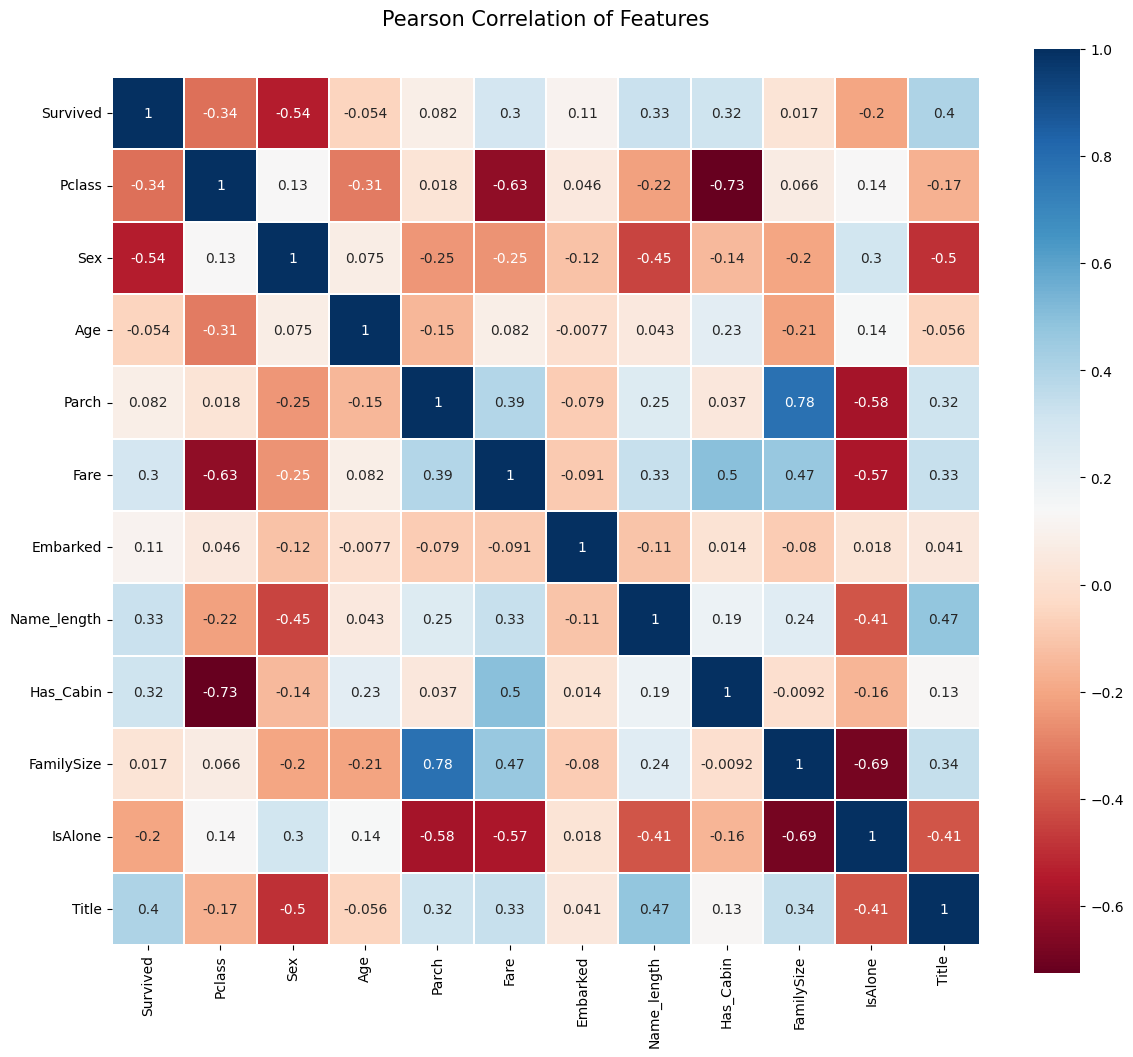

In [11]:
colormap = plt.cm.RdBu
plt.figure(figsize=(14,12))
plt.title('Pearson Correlation of Features',y=1.05,size=15)
sns.heatmap(train.astype(float).corr(),linewidths=0.1,vmax=1.0,
           square=True, cmap=colormap, linecolor='white',annot=True)

피어슨 상관관계 플로세서 알 수 있는 한가지는 서로 밀접한 상관관계가 있는 feature이 너무 많지 않다는 것.
이는 학습 모델에 이러한 feature을 제공하는 관점에서 볼 때 train세트에 중복되거나 불필요한 데이터가 많지 않다는 것을 의미하며 각 feature에 고유한 정보가 포함되어 있다는 점에서 좋음.
가장 상관관계가 높은 두가지 feature은 FamilySize와 Parch(부모 및 자녀)의 feature임

**Pairplots**

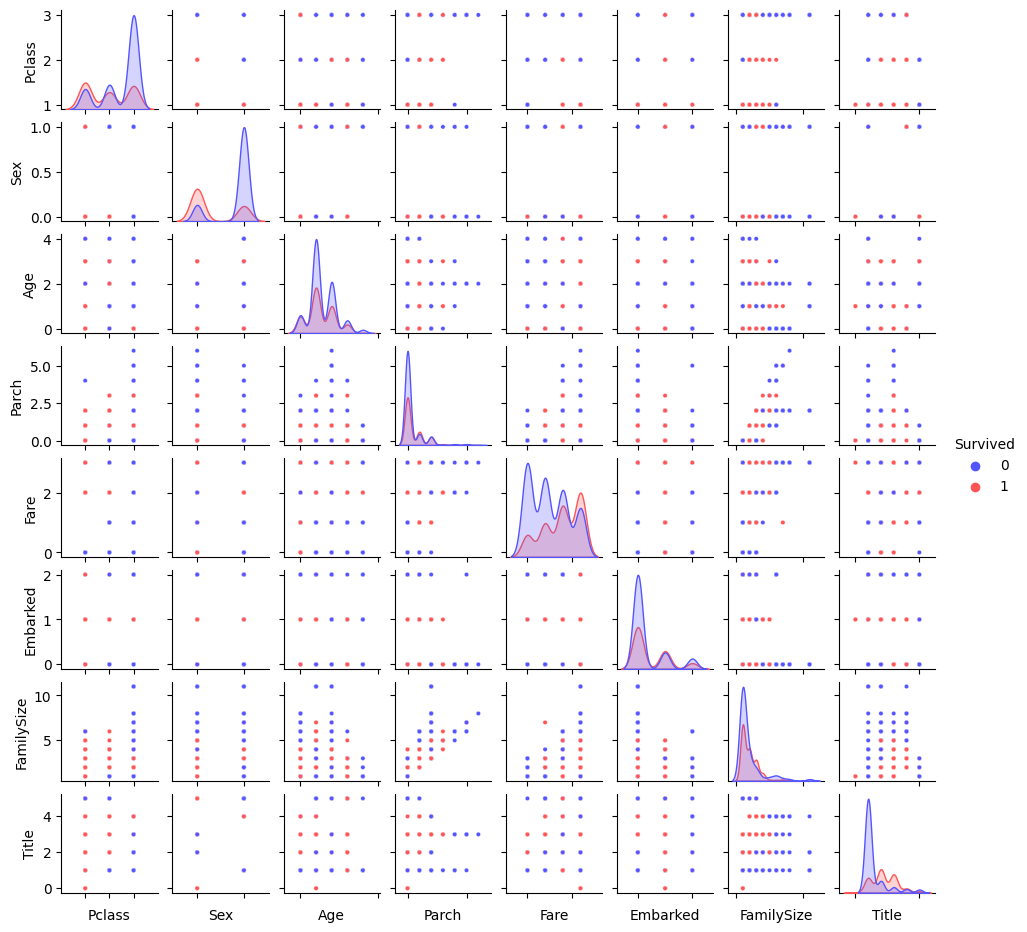

In [12]:
g = sns.pairplot(train[[u'Survived',u'Pclass',u'Sex',u'Age',u'Parch',u'Fare',
                        u'Embarked',u'FamilySize',u'Title']],hue='Survived',
                palette = 'seismic',size=1.2,diag_kind = 'kde',
                diag_kws=dict(shade=True),plot_kws=dict(s=10))
g.set(xticklabels=[])

# 3. Ensembling & Stacking models

In [13]:
# Some useful parameters which will come in handy later on

ntrain = train.shape[0]
ntest = test.shape[0]
SEED = 0 # for reproducibility
NFOLDS = 5 # set folds for out-of-fold prediction
kf = KFold(n_splits= NFOLDS, shuffle=True,random_state=SEED)

# Class to extend the Sklearn classifier
class SklearnHelper(object):
    def __init__(self,clf,seed=0,params=None):
        params['random_state'] = seed
        self.clf = clf(**params)

    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)

    def predict(self, x):
        return self.clf.predict(x)

    def fit(self, x, y):
        return self.clf.fit(x,y)

    def feature_importances(self,x,y):
        print(self.clf.fit(x,y).feature_importances_)

# Class to extend XGboost classifier